# Logistic Regression Model

In [1]:
import pandas as pd
import sys
import os
sys.path.append(os.getcwd()[:-18])
from source.eda_utils import get_dataFrame_withShortCols, data_cleaner, preprocess_data
from source.ml_utils import calculate_non_correlated_features, print_results, plot_roc
import seaborn as snus
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


In [2]:
# preprocessed data 
train_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('development_sample.csv')))
val_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('testing_sample.csv')))

c:\Users\mikol\PycharmProjects\Pre-selection Assignment\Pre-selection-Assignment\source\eda_utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_purpose_1_0'] = ((df_loan_purpose['loan_purpose_1.0'] == 1) & (df['Clasification of the vehicle'] == 0)).astype(int)
c:\Users\mikol\PycharmProjects\Pre-selection Assignment\Pre-selection-Assignment\source\eda_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_purpose_1_1'] = ((df_loan_purpose['loan_purpose_1.0'] == 1) & (df['Clasific

## Old Model 

In [ ]:
cm_r = confusion_matrix(train_data['Default indicator'], (train_data['_r_'] > 0.5).astype(int))
accuracy_r = accuracy_score(train_data['Default indicator'], (train_data['_r_'] > 0.5).astype(int))
cm_r, accuracy_r


(array([[17294, 17003],
        [  533,   562]], dtype=int64),
 0.5045207956600362)

In [ ]:
cm_r = confusion_matrix(val_data['Default indicator'], (val_data['_r_'] > 0.5).astype(int))
accuracy_r = accuracy_score(val_data['Default indicator'], (val_data['_r_'] > 0.5).astype(int))
cm_r, accuracy_r


(array([[1724, 1703],
        [  61,   58]], dtype=int64),
 0.5025380710659898)

## Benchmark Model

In [3]:
X_train = train_data.drop(columns=['Default indicator', '_r_', 'Application date'])
y_train = train_data['Default indicator']

X_val = val_data.drop(columns=['Default indicator', '_r_', 'Application date'])
y_val = val_data['Default indicator']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [4]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train_scaled))
logit_result = logit_model.fit(maxiter=1000)

y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)
print_results(y_val, y_pred)

Optimization terminated successfully.
         Current function value: 0.114605
         Iterations 9
Accuracy: 0.9670050761421319
Confusion Matrix:
[[3427    0]
 [ 117    2]]


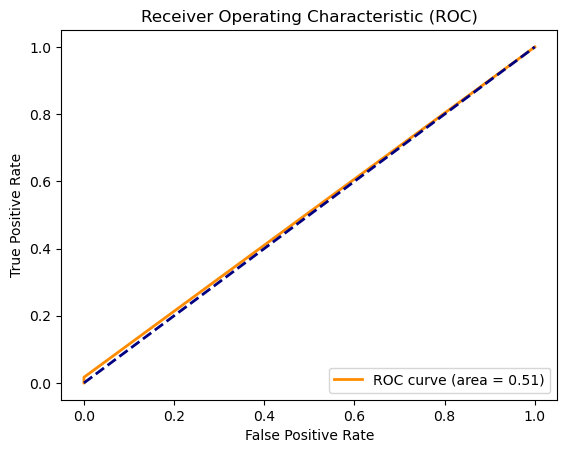

In [5]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plot_roc(fpr, tpr)

## Model without correlated variables

In [6]:
selected_features = calculate_non_correlated_features(X_train, 0.50)


In [7]:
len(selected_features)

26

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[selected_features])
X_val_scaled = scaler.transform(X_val[selected_features])


In [9]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train_scaled))
logit_result = logit_model.fit(maxiter=1000)

y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)
print_results(y_val, y_pred)


Optimization terminated successfully.
         Current function value: 0.126122
         Iterations 9
Accuracy: 0.9664410603496898
Confusion Matrix:
[[3426    1]
 [ 118    1]]


In [10]:
selected_features

['Credit duration',
 'Limit on credit card',
 'Amount on current account',
 'Amount on savings account',
 'Credit bureau score',
 'work experience',
 'loan_purpose_1_0',
 'loan_purpose_2_0',
 'loan_purpose_2_1',
 'Distribution channel_2',
 'Distribution channel_3',
 'Payment frequency_3',
 'profession of main applicant_2',
 'profession of main applicant_3',
 'profession of main applicant_6',
 'profession of main applicant_7',
 'profession of second applicant_1.0',
 'profession of second applicant_2.0',
 'profession of second applicant_3.0',
 'profession of second applicant_4.0',
 'profession of second applicant_6.0',
 'profession of second applicant_7.0',
 'marital status of main applicant_1',
 'marital status of main applicant_2',
 'marital status of main applicant_3',
 'marital status of main applicant_4']

## Over sampling

In [26]:
smot = SMOTE(sampling_strategy=0.3, random_state=42)

oversampled_X, oversampled_Y = smot.fit_resample(X_train_scaled, y_train)
readyDF = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
readyDF['Default indicator'].value_counts()


Default indicator
0.0    34297
1.0    10289
Name: count, dtype: int64

In [27]:
logit_model = sm.Logit(oversampled_Y, sm.add_constant(oversampled_X))
logit_result = logit_model.fit(maxiter=1000)

y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)
print_results(y_val, y_pred)



Optimization terminated successfully.
         Current function value: 0.473744
         Iterations 6
Accuracy: 0.9498025944726453
Confusion Matrix:
[[3352   75]
 [ 103   16]]


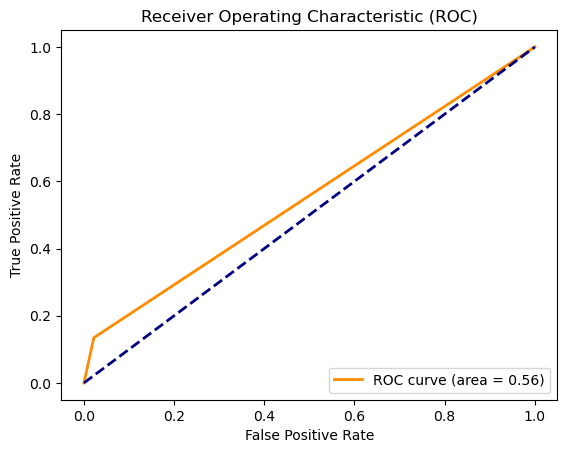

In [28]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plot_roc(fpr, tpr)

In [14]:
smot = SMOTE(sampling_strategy=1, random_state=42)

oversampled_X, oversampled_Y = smot.fit_resample(X_train_scaled, y_train)
readyDF = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
readyDF['Default indicator'].value_counts()

Default indicator
0.0    34297
1.0    34297
Name: count, dtype: int64

In [15]:
logit_model = sm.Logit(oversampled_Y, sm.add_constant(oversampled_X))
logit_result = logit_model.fit(maxiter=1000)

y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)
print_results(y_val, y_pred)

Optimization terminated successfully.
         Current function value: 0.605365
         Iterations 7
Accuracy: 0.6765369430344049
Confusion Matrix:
[[2325 1102]
 [  45   74]]


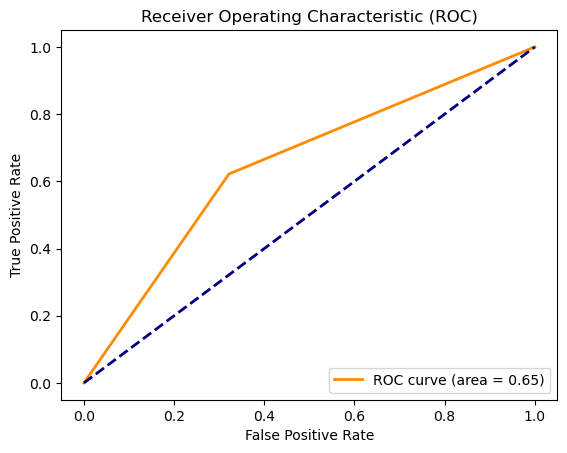

In [16]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plot_roc(fpr, tpr)